## Rydberg Rabi Flopping Simulation

Compares scipy.integrate solve_ivp and complex_ode performance  
TODO: try to use 1j instead of I in generated eqs; may be ~ 20 times faster.

In [18]:
# not all of these import necessary; many are for debugging
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp, complex_ode
from sympy import MatrixSymbol,MatMul,Matrix,symbols,Function,pi
from sympy.utilities.lambdify import lambdify
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan
from sympy.physics.quantum import TensorProduct as TP
from sympy.physics.quantum.commutator import Commutator as comm
import sympy as sp
from numpy import *
from arc import *
import time
import os, sys

# local files in parent directory
sys.path.append(os.path.join('..',''))
from physconsts import *
from rbconsts import *
from amophys import hf_coupling
from atomsim import AtomSim, comm

basis states: (might need more to properly handle decay)  
$|{0}\rangle = |5s_{1/2},F=3,m_F=0\rangle$  
$|{1}\rangle = |5s_{1/2},F=2,m_F=0\rangle$  
$|{e}\rangle = |5p_{3/2},F=2,m_F=1\rangle$  
$|{r}\rangle = |84d_{5/2},J=3/2,m_J=3/3\rangle$

## Rabi Flopping with hard-coded Hamiltonian

In [3]:
# build the hamiltonian

# O1max = 2*pi
# O2max = O1max
# O2 = O2max # constant field intensity
# O1 = O1max # constant field intensity
# D1 = 10*O1max 
# D2 = -D1#  + (O1(t)**2 - O2(t)**2)/(4*D1) # keeps two-photon detuning = 0
# O = abs(O1max*O2max/(2*D1))/(2*pi)
# print(f"Two-photon Rabi frequency = 2*pi*{O:.2f} [arb]")

# H = Matrix([[0,  0,    0,    0],
#             [0,  0,   O1/2,  0],
#             [0, O1/2,  -D1, O2/2],
#             [0,   0,   O2/2, -(D1+D2)]])

# Chris's Hamiltonian. Takes like 30s to do only 10 cycles
# values in GHz
O1 = -2*0.443992
O2 = -2*.0616463
D1 = -13.1947
D12 = 0.0145

H = Matrix([[0, O1/2, 0],
            [O1/2, D1, O2/2],
            [0, O2/2, D12]])

In [40]:
## set up the simulation 
dim = H.shape[0]
rho0 = zeros(int(dim*(dim + 1)/2), complex)
rho0[0] = 1 + 0j # population starts in ground state
sim = AtomSim(rho0, t_exp=10, hamiltonian=H, _hbar=1)
sim.eqs

[-1.0*I*(-0.443992*r01 + 0.443992*conjugate(r01)),
 -1.0*I*(-0.443992*r00 - 13.1947*r01 - 0.0616463*r02 + 0.443992*r11),
 -1.0*I*(-0.0616463*r01 + 0.0145*r02 + 0.443992*r12),
 -1.0*I*(0.443992*r01 - 0.0616463*r12 - 0.443992*conjugate(r01) + 0.0616463*conjugate(r12)),
 -1.0*I*(0.443992*r02 - 0.0616463*r11 + 13.2092*r12 + 0.0616463*r22),
 -1.0*I*(0.0616463*r12 - 0.0616463*conjugate(r12))]

In [59]:
for eq in sim.eqs:
    print()

-1.0*I*(-0.443992*r01 + 0.443992*conjugate(r01))
-1.0*I*(-0.443992*r00 - 13.1947*r01 - 0.0616463*r02 + 0.443992*r11)
-1.0*I*(-0.0616463*r01 + 0.0145*r02 + 0.443992*r12)
-1.0*I*(0.443992*r01 - 0.0616463*r12 - 0.443992*conjugate(r01) + 0.0616463*conjugate(r12))
-1.0*I*(0.443992*r02 - 0.0616463*r11 + 13.2092*r12 + 0.0616463*r22)
-1.0*I*(0.0616463*r12 - 0.0616463*conjugate(r12))


In [54]:
runs = 100000
I_time = 0
j_time = 0
for i in range(runs):
    t0 = time.perf_counter_ns()
    sp.I**2
    I_time += time.perf_counter_ns()-t0
    
    t0 = time.perf_counter_ns()
    1j**2
    j_time += time.perf_counter_ns()-t0
    
print(f'I_time={0.001*I_time/runs} [us]')
print(f'j_time={0.001*j_time/runs} [us]')

I_time=10.156103 [us]
j_time=0.561866 [us]


Run time: 9.460695505142212


Text(0.5, 1.0, 'Three Level Rabi Flopping')

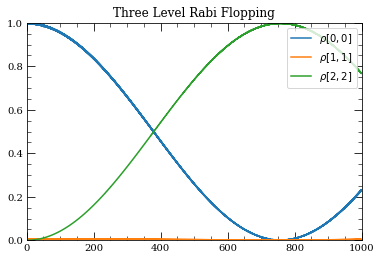

In [28]:
# Solve with solve_ivp wrapped in AtomSim.runsim
t0 = time.time()
rho, t = sim.runsim(t_exp=1000)
print(f"Run time: {time.time() - t0}")
kwargs = {'figsize':(6,4)}
fig, axes = sim.plots(show=['populations'], coherences=False,
                      plt_kwargs=kwargs)
ax = axes[0]
ax.set_ylim((0,1))
ax.set_title('Three Level Rabi Flopping')

In [21]:
# Solve with complex_ode

# help(sim.derivs)
t0 = 0
solver = complex_ode(sim.derivs)
solver.set_initial_value(rho0, t0)

t1 = sim.t_exp
dt = 1
gsoln = zeros(int(t1/dt)) # ground state solution

In [ ]:
i = 0
t0 = time.time()
while solver.successful() and i < len(gsoln):
    gsoln[i] = solver.integrate(solver.t+dt)[i]
    i = i + 1
print(f"Run time: {time.time() - t0}")

plt.plot(tsoln, gsoln)